In [206]:
using DelimitedFiles
using PyCall
using PyPlot
using Random
using Setfield
using Statistics
using ProgressMeter
using JLD2
using HDF5
using Printf
using FileIO
using DataStructures
using DrWatson

using Revise

using CMBLensing
using PtsrcLens

# Load pre-processed

In [320]:
@load "data/sehgal_maps_h5/cutouts.jld2"

5-element Array{Symbol,1}:
 :ϕs
 :κs
 :gs_ir
 :gs_radio
 :Ms_radio

In [189]:
gs = Dict(:radio => gs_radio, :ir => gs_ir)
Ms = Dict(:radio => Ms_radio, :ir => DefaultDict(DefaultDict(ones(length(ϕs)))));

# Check power

In [190]:
@unpack (μKarcmin_gs_radio, μKarcmin_gs_ir) = get_foreground_whitenoise_level(;Ms_radio, gs_radio, gs_ir);

In [191]:
tab = pyimport("pandas").DataFrame(
    OrderedDict(
        fluxcut => OrderedDict(
            freq => mean(skipmissing(μKarcmin_gs_radio[survey,freq,fluxcut] for survey in [:deep,:wide])) 
            for freq in [90,148]
        ) for fluxcut in reverse(fluxcuts)
    )
)
println(tab.to_latex())
tab

\begin{tabular}{lrrrr}
\toprule
{} &      inf  &      10.0 &      5.0  &      2.0  \\
\midrule
90  &  1.464721 &  0.184565 &  0.131259 &  0.075241 \\
148 &  0.632798 &  0.081312 &  0.057939 &  0.034663 \\
\bottomrule
\end{tabular}



,inf,10.0,5.0,2.0
90,1.464721,0.184565,0.131259,0.075241
148,0.632798,0.081312,0.057939,0.034663


In [192]:
μKarcmin_gs = Dict(:radio=>μKarcmin_gs_radio, :ir=>μKarcmin_gs_ir);

# Plot

In [15]:
figure(figsize=(3*6.4,4))

for (j,freq) in enumerate([90,150])
    
    for (i,fgtype) in enumerate([:radio,:ir])
        
        ax = subplot(1,4,2*(i-1)+j)
        
        if (freq,fgtype) != (90,:ir)

            for (c,fluxcut) in enumerate(keys(μKarcmin_gs[fgtype][freq]))
                let (Ms, gs, μKarcmin) = (Ms[fgtype][freq][fluxcut], gs[fgtype][freq], μKarcmin_gs[fgtype][freq][fluxcut])
                    for k in sims
                        loglog(get_Cℓ(Ms[k] * gs[k], which=:QQ), c="C$(c-1)", alpha=0.5)
                    end
                    axhline(noiseCℓs(μKarcminT=μKarcmin/√2, ℓknee=0).EE[2], c="C$(c-1)", ls="--", label="average power spectrum")
                end
            end
            
        end

        loglog(Cℓ.unlensed_scalar.EE, "k")
        loglog(Cℓ.lensed_scalar.BB, "k")
        loglog(Cℓ.tensor.BB, "k-.")
        axhline(2.8e-7, c="gray", ls="-.", label="Crites et al. 2015")
        axhline(noiseCℓs(μKarcminT=1, αknee=0).TT[2], c="gray", ls=":", label="1 μKarcmin noise")

        title("$(["Radio","IR"][i]), $([90,148][j])GHz")
        
        ylim(1e-11, 1e0)
        xlim(20,1.4e4)
        if i==j==1
            ylabel(L"C_\ell")
        else
            ax.set_yticklabels([])
        end
        xlabel(L"\ell")
        
    end

end
subplots_adjust(wspace=0.05)
savefig("figures/powerspectra.pdf", bbox_inches="tight")

LoadError: KeyError: key 90 not found

# Analyze MAPs

In [207]:
# ℓedges = round.(Int, 10 .^ range(log10(25), log10(6000), length=10));
# ℓedges = [25, 50, 75, 100, 134, 182, 245, 331, 447, 603, 814, 1098, 1482, 1998, (3000:1000:6000)...];
ℓedges = [2:100:500; round.(Int, 10 .^ range(log10(502), log10(6000), length=10))];

In [208]:
ℓcenters = (ℓedges[1:end-1] .+ ℓedges[2:end]) ./ 2;
Δℓ = (ℓedges[2:end] .- ℓedges[1:end-1]);
nℓbins = length(ℓcenters);

In [209]:
Cℓ = get_fiducial_Cℓ(ϕs);

In [361]:
survey = :deep
ℓmax_data = 3000
polfrac_scale = 1
fluxcut = 5
freq = 90;
Nbatch = 1;

In [364]:
MAPs = CMBLensing.Chains(load(datadir("MAPs", savename((;survey,freq,ℓmax_data,fluxcut,polfrac_scale,Nbatch), "jld2")),"MAPs"));

LoadError: File{DataFormat{:UNKNOWN}}("/global/home/users/mariusmillea/work/ptsrclens/data/MAPs/Nbatch=1_fluxcut=5_freq=90_polfrac_scale=1_survey=deep_ℓmax_data=3000.jld2") couldn't be recognized by FileIO.


In [363]:
Base.getindex(f::FlatS0, ::typeof(!), i::Int) = batchindex(f,i)

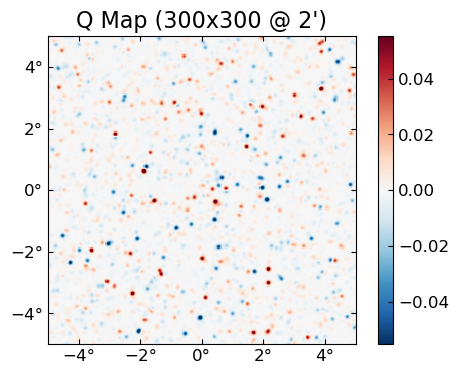

In [331]:
plot(BandPassOp(beamCℓs(beamFWHM=5)) * MAPs[1][:corrfg,:fgcov].M * MAPs[1][:corrfg,:fgcov].g, which=:Qx)

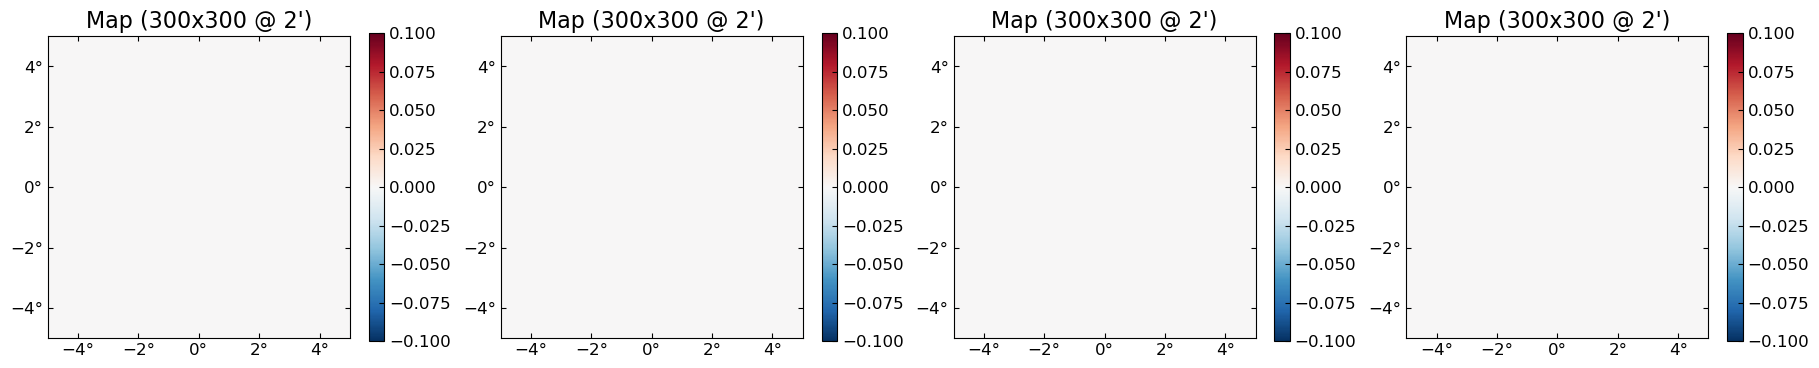

In [332]:
plot([∇²] .* ([MAPs[1][:nofg,:fgcov].ϕ[!,1] MAPs[1][:corrfg,:nocov].ϕ[!,1] MAPs[1][:uncorrfg,:fgcov].ϕ[!,1] MAPs[1][:gaussfg,:fgcov].ϕ[!,1]] .- [MAPs[1][:nofg,:nocov].ϕ[!,1]]))

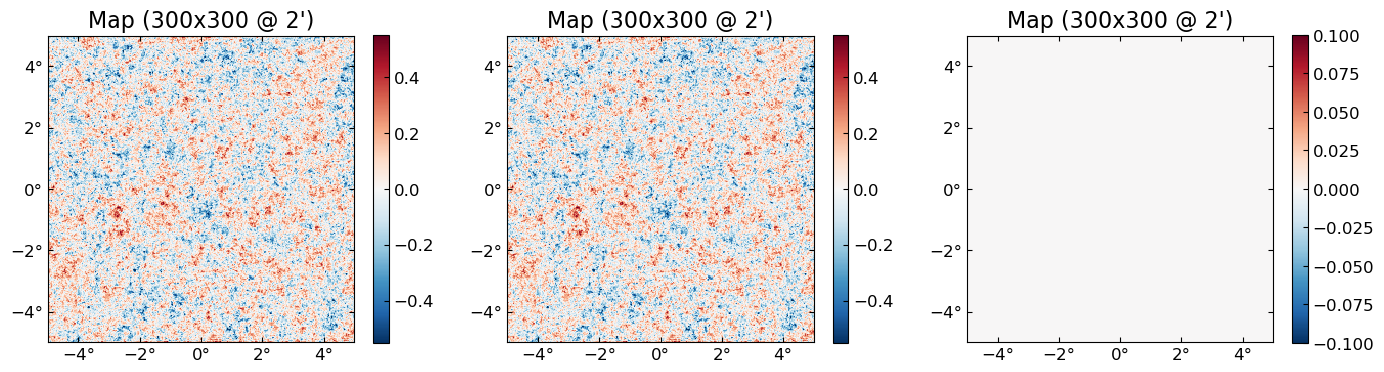

In [333]:
plot([∇²] .* [batchindex(MAPs[1][:nofg,:fgcov].ϕ,1) batchindex(MAPs[1][:corrfg,:fgcov].ϕ,1) batchindex(MAPs[1][:corrfg,:fgcov].ϕ - MAPs[1][:nofg,:fgcov].ϕ,1)])

In [334]:
_unbatch(x) = [batch(x,i) for i=1:CMBLensing.batchsize(x)];

In [343]:
mean_ρℓ(k...) = mean(get_ρℓ(ϕJ,ϕs[i];ℓedges) for i in 1:8 for ϕJ in _unbatch(MAPs[i][k...].ϕJ))
mean_Cℓ(k...) = mean(get_Cℓ(ϕJ,ϕs[i];ℓedges) for i in 1:8 for ϕJ in _unbatch(MAPs[i][k...].ϕJ))
get_gs(MAP,k...) = vcat([hcat(unbatch.(g)...) for g in MAPs[:,k,:gAϕ]]...)';

In [344]:
# Cℓ_bias = Cℓ.total.ϕϕ * ((1/mean_ρℓ(:corrfg,:fgcov)^2 - 1) - (1/mean_ρℓ(:nofg,:fgcov)^2 - 1));

In [345]:
Cℓ_noise = Cℓ.total.ϕϕ * (1/mean_ρℓ(:uncorrfg,:fgcov)^2 - 1);

In [346]:
fsky = (survey==:deep ? 0.03 : 0.6)

0.03

In [347]:
σℓ = (ℓ⁴ * (Cℓ.total.ϕϕ + Cℓ_noise) * CMBLensing.FuncCℓs(ℓ -> √(2/((2ℓ+1)*fsky))))[ℓcenters] ./ sqrt.(Δℓ);

In [348]:
# Tℓ = mean_Cℓ(:nofg,:fgcov) / mean(get_Cℓ(ϕs[i], ℓedges=ℓedges) for i=sims);

In [349]:
# Cℓ_bias = Tℓ^(-2.) * (mean_Cℓ(:uncorrfg,:fgcov) - mean_Cℓ(:nofg,:fgcov));

In [359]:
ℓslice = 1:11
bias = sqrt(fsky/(100/rad2deg(rad2deg(4π)))) * sum(mean(get_gs(MAPs,:uncorrfg,:fgcov)[ℓslice,:],dims=2) - mean(get_gs(MAPs,:gaussfg,:fgcov)[ℓslice,:],dims=2)) / std(sum(get_gs(MAPs,:gaussfg,:fgcov)[ℓslice,:], dims=1))

-0.031971624392281676

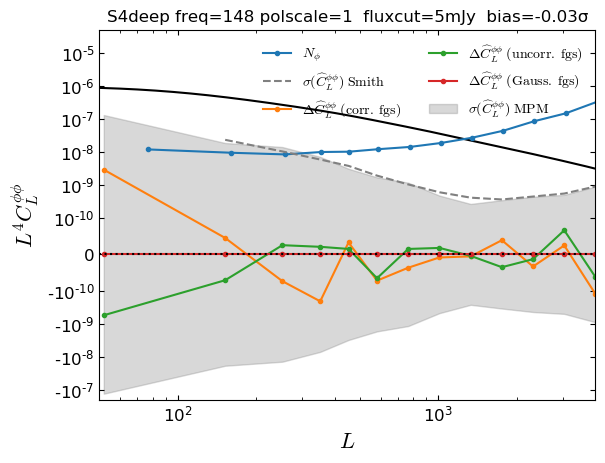

PyObject Text(41.277777777777786, 0.5, '$L^4 C_L^{\\phi\\phi}$')

In [360]:
loglog(ℓ⁴*Cℓ.total.ϕϕ,"k")
loglog(ℓ⁴*Cℓ_noise, ".-", label=L"N_\phi")

plot(ℓcenters, σℓ, c="gray", ls="--", label=L"\sigma(\widehat C_L^{\phi\phi}) \; {\rm Smith}")

fill_between(
    ℓcenters, 
    (x * 1/sqrt(fsky/(100/rad2deg(rad2deg(4π)))) * Cℓ.total.ϕϕ[ℓcenters] .* ℓcenters.^4 ./ std(get_gs(MAPs,:nofg,:fgcov),dims=2)[:] for x=[1,-1])...,
    color="gray", alpha=0.3, ls="-", label=L"\sigma(\widehat C_L^{\phi\phi}) \; {\rm MPM}"
)

plot(
    ℓcenters, 
    Cℓ.total.ϕϕ[ℓcenters] .* ℓcenters.^4 .* (mean(get_gs(MAPs,:corrfg,:fgcov),dims=2)   - mean(get_gs(MAPs,:gaussfg,:fgcov),dims=2)) ./ var(get_gs(MAPs,:gaussfg,:fgcov),dims=2),
    ".-",
    label=L"\Delta \widehat C_L^{\phi\phi} \; (\rm corr. \; fgs)"
)
plot(
    ℓcenters, 
    Cℓ.total.ϕϕ[ℓcenters] .* ℓcenters.^4 .* (mean(get_gs(MAPs,:uncorrfg,:fgcov),dims=2) - mean(get_gs(MAPs,:gaussfg,:fgcov),dims=2)) ./ var(get_gs(MAPs,:gaussfg,:fgcov),dims=2),
    ".-",
    label=L"\Delta \widehat C_L^{\phi\phi} \; (\rm uncorr. \; fgs)"
)
plot(
    ℓcenters, 
    Cℓ.total.ϕϕ[ℓcenters] .* ℓcenters.^4 .* (mean(get_gs(MAPs,:gaussfg,:fgcov),dims=2) - mean(get_gs(MAPs,:gaussfg,:fgcov),dims=2)) ./ var(get_gs(MAPs,:gaussfg,:fgcov),dims=2),
    ".-",
    label=L"\Delta \widehat C_L^{\phi\phi} \; (\rm Gauss. \; fgs)"
)



axhline(0,c="k",ls=":")
title(@sprintf("S4%s freq=%i polscale=%i  fluxcut=%imJy  bias=%.2fσ", survey, freq, polfrac_scale, fluxcut, bias), fontsize=12)

legend(ncol=2, fontsize=10, loc="upper right")
xlim(50,4000)
yscale("symlog", linthreshy=1e-10)
ylim(-2e-7,5e-5)

xlabel(L"L")
ylabel(L"L^4 C_L^{\phi\phi}")

# savefig("figures/radio_$(freq)GHz_S4$(noise_key)_lmax$(ℓmax_data)_fluxcut$(fluxcut)mJy_polfracscale$(polfrac_scale).pdf", bbox_inches="tight")

# Maps

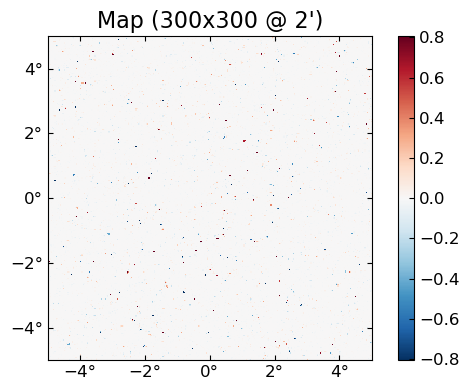

In [140]:
plot(gs_radio[150][1][:Q])

In [ ]:
plot(
    permutedims([
        diag(Ms_radio[150][2][1])[:Q],
        ∇² * batchindex(MAPs[1][:nofg,:fgcov].ϕ,1)/2,
        ∇² * (batchindex(MAPs[1][:corrfg,:fgcov].ϕ,1) - batchindex(MAPs[1][:nofg,:fgcov].ϕ,1))/2
    ]),
    title = [L"{\rm mask} \; (S_{\rm cut}^{150}=2\,{\rm mJy})" L"\hat \kappa_{\rm J}^{\rm no\,fgs}" L"\hat \kappa_{\rm J}^{\rm fgs} - \hat \kappa_{\rm J}^{\rm no\,fgs}"],
    vlim = [(0,1) 0.16 0.016],
    cmap = ["Greys" "RdBu_r" "RdBu_r"]
)

In [ ]:
plot(, which=[:Qx])

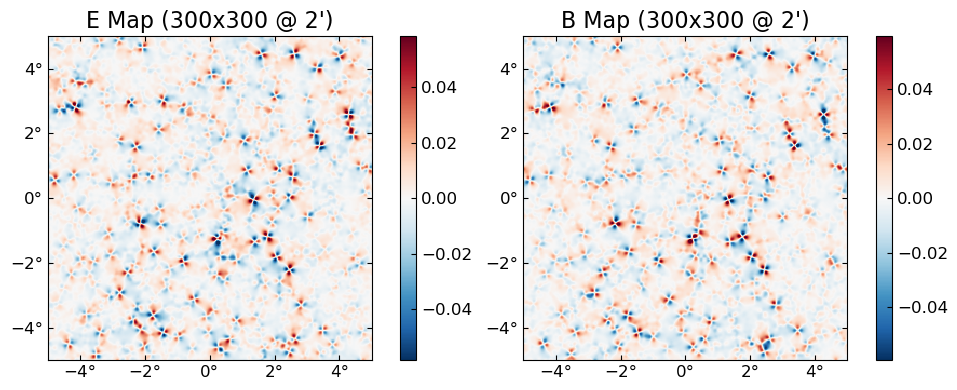

In [195]:
plot(BandPassOp(beamCℓs(beamFWHM=5)) * (Ms_radio[150][10][1]*gs_radio[150][1]))

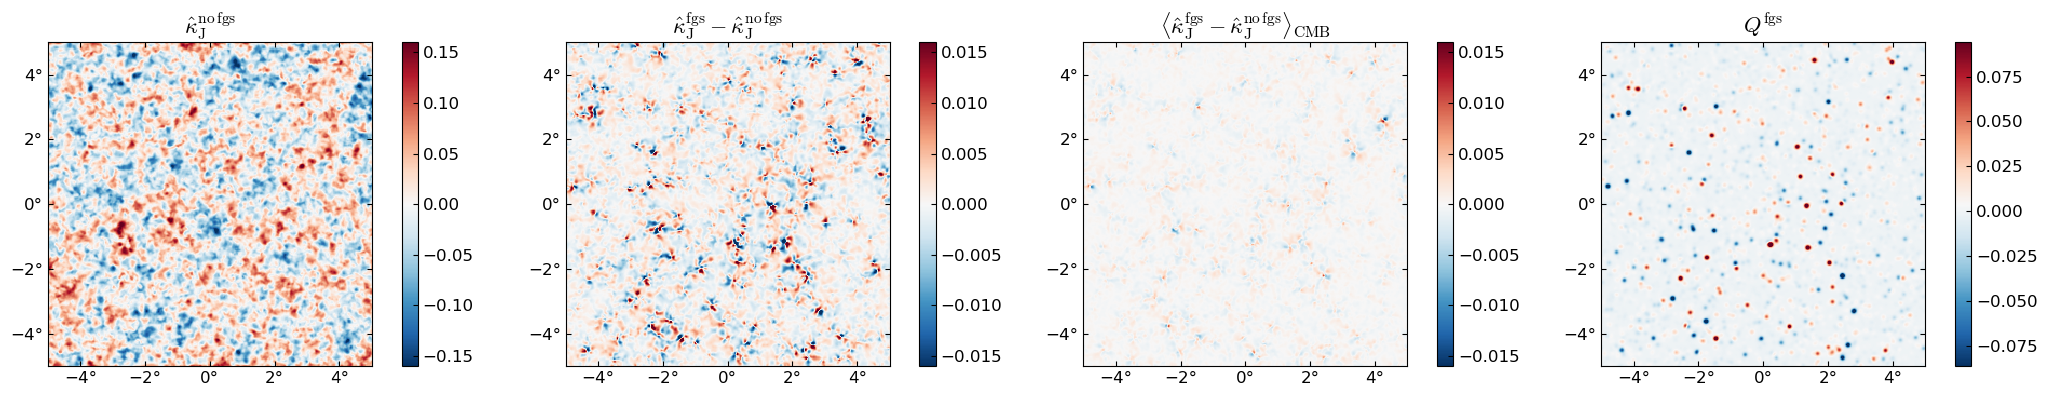

In [191]:
plot(
    permutedims([
        ∇² * batchindex(MAPs[1][:nofg,:fgcov].ϕ,1)/2,
        ∇² * unbatch(MAPs[1][:corrfg,:fgcov].ϕ - MAPs[1][:nofg,:fgcov].ϕ)[1]/2,
        ∇² * mean(unbatch(MAPs[1][:corrfg,:fgcov].ϕ - MAPs[1][:nofg,:fgcov].ϕ))/2,
        BandPassOp(beamCℓs(beamFWHM=5)) * (Ms_radio[150][10][1]*gs_radio[150][1])[:Q]
    ]),
    title = [L"\hat \kappa_{\rm J}^{\rm no\,fgs}" L"\hat \kappa_{\rm J}^{\rm fgs} - \hat \kappa_{\rm J}^{\rm no\,fgs}" L"\langle \hat \kappa_{\rm J}^{\rm fgs} - \hat \kappa_{\rm J}^{\rm no\,fgs} \rangle_{\rm CMB}" L"Q^{\rm fgs}"],
    vlim = [0.16 0.016 0.016 :asym],
)

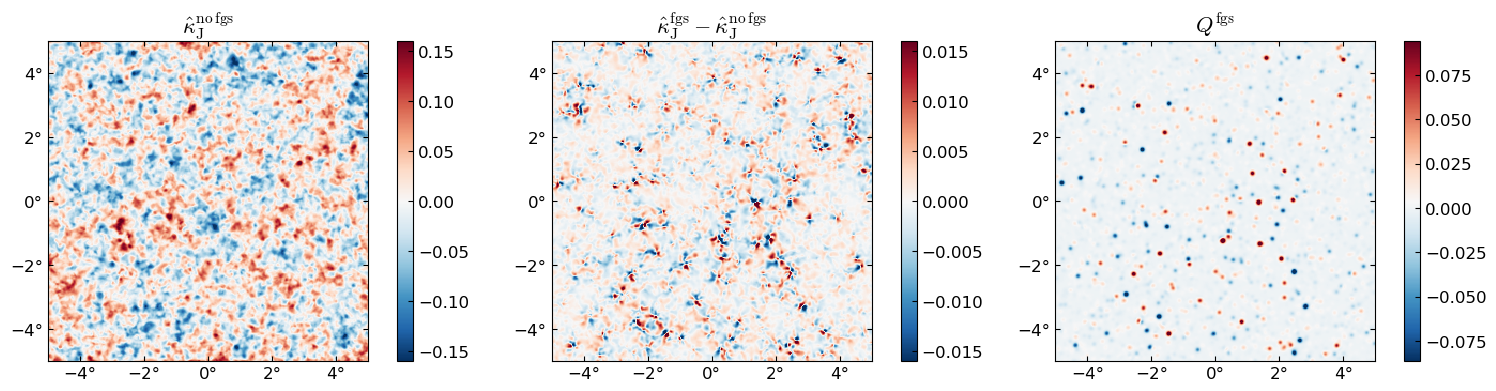

In [157]:
plot(
    permutedims([
        ∇² * batchindex(MAPs[1][:nofg,:fgcov].ϕ,1)/2,
        ∇² * (batchindex(MAPs[1][:corrfg,:fgcov].ϕ,1) - batchindex(MAPs[1][:nofg,:fgcov].ϕ,1))/2,
        BandPassOp(beamCℓs(beamFWHM=5)) * (Ms_radio[150][10][1]*gs_radio[150][1])[:Q]
    ]),
    title = [L"\hat \kappa_{\rm J}^{\rm no\,fgs}" L"\hat \kappa_{\rm J}^{\rm fgs} - \hat \kappa_{\rm J}^{\rm no\,fgs}" L"Q^{\rm fgs}"],
    vlim = [0.16 0.016 :asym],
)

In [ ]:
@time map(collect(noises)) do (noise_key, noise_kwargs)
    map([3000,5000]) do ℓmax_data
        map([2,10]) do fluxcut
            map([1,2]) do polfrac_scale

                filename = "MAPs/radio_148GHz_S4$(noise_key)_lmax$(ℓmax_data)_fluxcut$(fluxcut)mJy_polfracscale$(polfrac_scale).jld2"
                
                if isfile(filename)
                
                    MAPs = load(filename, "MAPs");

                    Cℓ_bias  = Cℓ.total.ϕϕ * ((1/mean(get_ρℓ(MAPs[i][:corrfg,:fgcov].ϕ, ϕs[i], ℓedges=ℓedges) for i=sims)^2 - 1) - (1/mean(get_ρℓ(MAPs[i][:nofg,:fgcov].ϕ, ϕs[i], ℓedges=ℓedges) for i=sims)^2 - 1))
                    Cℓ_noise = Cℓ.total.ϕϕ *  (1/mean(get_ρℓ(MAPs[i][:corrfg,:fgcov].ϕ, ϕs[i], ℓedges=ℓedges) for i=sims)^2 - 1);
                    fsky = (noise_key==:deep ? 1500 : 20000) / 42000
                    σℓ = (Cℓ.total.ϕϕ + Cℓ_noise) * CMBLensing.FuncCℓs(ℓ -> √(2/((2ℓ+1)*fsky)));

                    Tℓ = mean(get_Cℓ(MAPs[i][:nofg,:fgcov].ϕ, ϕs[i], ℓedges=ℓedges) for i=sims) / mean(get_Cℓ(ϕs[i], ℓedges=ℓedges) for i=sims)

                    
                    map([100:2000, 100:3000]) do ℓrange_Aϕ

                        b̂ = sum((Cℓ_bias / σℓ^2)[ℓrange_Aϕ]) / sum((1 / σℓ^2)[ℓrange_Aϕ])
                        σb̂ = 1 / sqrt(sum((1 / σℓ^2)[ℓrange_Aϕ]))
                        b̂ / σb̂

                        fgcov=:fgcov

                        figure()

                        loglog(ℓ⁴ * Cℓ.total.ϕϕ,"k")
                        for i=sims
                            loglog(ℓ⁴ * Cℓ.total.ϕϕ *  (1/get_ρℓ(MAPs[i][:corrfg,  fgcov].ϕ, ϕs[i], ℓedges=ℓedges)^2 - 1), "C0", alpha=0.1)
#                             loglog(ℓ⁴ * Cℓ.total.ϕϕ * ((1/get_ρℓ(MAPs[i][:corrfg,  fgcov].ϕ, ϕs[i], ℓedges=ℓedges)^2 - 1) - (1/get_ρℓ(MAPs[i][:nofg,fgcov].ϕ, ϕs[i], ℓedges=ℓedges)^2 - 1)),"C1",alpha=0.1)
#                             loglog(ℓ⁴ * Cℓ.total.ϕϕ * ((1/get_ρℓ(MAPs[i][:uncorrfg,fgcov].ϕ, ϕs[i], ℓedges=ℓedges)^2 - 1) - (1/get_ρℓ(MAPs[i][:nofg,fgcov].ϕ, ϕs[i], ℓedges=ℓedges)^2 - 1)),"C2",alpha=0.1)    
                        end
                        loglog(ℓ⁴ * Cℓ.total.ϕϕ * ( 1/mean(get_ρℓ(MAPs[i][:corrfg,  fgcov].ϕ, ϕs[i], ℓedges=ℓedges) for i=sims)^2 - 1), 
                            "C0", label="noise")
                        loglog(ℓ⁴ * Cℓ.total.ϕϕ * ((1/mean(get_ρℓ(MAPs[i][:corrfg,  fgcov].ϕ, ϕs[i], ℓedges=ℓedges) for i=sims)^2 - 1) - (1/mean(get_ρℓ(MAPs[i][:nofg,fgcov].ϕ, ϕs[i], ℓedges=ℓedges) for i=sims)^2 - 1)),
                            "C1", label="foreground bias (spatially correlated)")
                        loglog(ℓ⁴ * Cℓ.total.ϕϕ * ((1/mean(get_ρℓ(MAPs[i][:uncorrfg,fgcov].ϕ, ϕs[i], ℓedges=ℓedges) for i=sims)^2 - 1) - (1/mean(get_ρℓ(MAPs[i][:nofg,fgcov].ϕ, ϕs[i], ℓedges=ℓedges) for i=sims)^2 - 1)),
                            "C2", label="foreground bias (spatially uncorrelated)")
                        loglog(ℓ⁴ * σℓ, c="gray",ls="--", label="σ(Cℓ) S4$(noise_key)")
                        plot(Tℓ^(-2.) * mean(get_ℓ⁴Cℓ(MAPs[i][:corrfg,  :fgcov].ϕ, ℓedges=ℓedges) - get_ℓ⁴Cℓ(MAPs[i][:nofg,:fgcov].ϕ, ℓedges=ℓedges) for i=sims),"C1--")
                        plot(Tℓ^(-2.) * mean(get_ℓ⁴Cℓ(MAPs[i][:uncorrfg,:fgcov].ϕ, ℓedges=ℓedges) - get_ℓ⁴Cℓ(MAPs[i][:nofg,:fgcov].ϕ, ℓedges=ℓedges) for i=sims),"C2--")
                        plot(Tℓ^(-2.) * mean(get_ℓ⁴Cℓ(MAPs[i][:corrfg,  :fgcov].ϕ - MAPs[i][:nofg,:fgcov].ϕ, ℓedges=ℓedges) for i=sims),"C1:")
                        plot(Tℓ^(-2.) * mean(get_ℓ⁴Cℓ(MAPs[i][:uncorrfg,:fgcov].ϕ - MAPs[i][:nofg,:fgcov].ϕ, ℓedges=ℓedges) for i=sims),"C2:")

                        axvspan(first(ℓrange_Aϕ), last(ℓrange_Aϕ), color="gray", alpha=0.2)

                        legend(loc="lower left",frameon=true)
                        yscale("symlog",linthreshy=1e-10)
                        ylim(-1e-8, 2e-6)
                        xlim(30,6000)
                        title(@sprintf("S4%s  polscale=%i  fluxcut=%imJy  bias=%.2fσ", noise_key, polfrac_scale, fluxcut, b̂ / σb̂), fontsize=14)
                        savefig(
                            "plots/radio_148GHz_S4$(noise_key)_lmax$(ℓmax_data)_fluxcut$(fluxcut)mJy_polfracscale$(polfrac_scale)_Aphi_$(first(ℓrange_Aϕ))_$(last(ℓrange_Aϕ)).pdf", 
                            bbox_inches="tight"
                        )
                        close()
                        
                    end
                    
                end
            end
        end
    end
end